# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

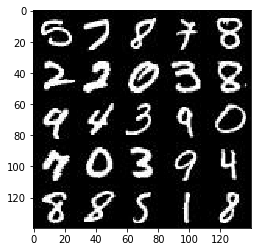

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

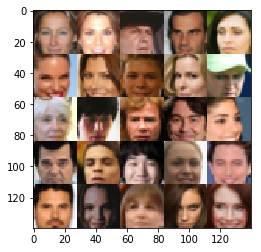

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 4.2400
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 4.3272... Generator Loss: 0.1464
Epoch 1/2... Discriminator Loss: 0.2142... Generator Loss: 2.6027
Epoch 1/2... Discriminator Loss: 0.8040... Generator Loss: 6.1107
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 0.0280... Generator Loss: 4.1299
Epoch 1/2... Discriminator Loss: 0.4692... Generator Loss: 2.3451
Epoch 1/2... Discriminator Loss: 0.1503... Generator Loss: 6.1087
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 12.6809


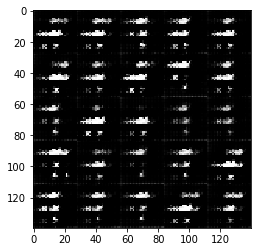

Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 5.2188
Epoch 1/2... Discriminator Loss: 0.2449... Generator Loss: 2.1628
Epoch 1/2... Discriminator Loss: 0.3478... Generator Loss: 2.5144
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 3.9650
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 3.4565
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 3.4221
Epoch 1/2... Discriminator Loss: 0.4519... Generator Loss: 4.3253
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 2.2877
Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 2.2598
Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 2.4896


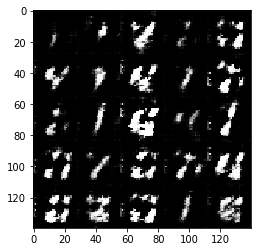

Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.7940
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 2.3734
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 2.5583
Epoch 1/2... Discriminator Loss: 3.2092... Generator Loss: 9.0439
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.1831
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.3955
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.7387
Epoch 1/2... Discriminator Loss: 0.4803... Generator Loss: 2.1545
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 2.7827
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 1.6046


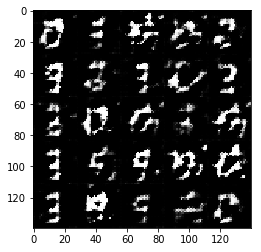

Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 2.6629
Epoch 1/2... Discriminator Loss: 0.5257... Generator Loss: 2.3433
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 2.3652
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 1.8830
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 1.0006
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.3626
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.8870
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 1.3082


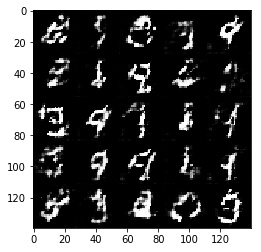

Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 2.0431
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 2.4906
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 4.3831
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 2.0685
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 2.1155
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 1.6987


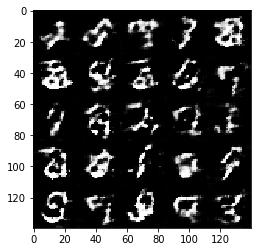

Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 1.8738
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 1.9858
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.6232
Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 3.0486
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5722
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.5822


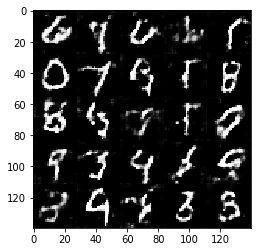

Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 3.4647
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 2.4798
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 2.5021
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.4232
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.6350
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.3847
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.1352


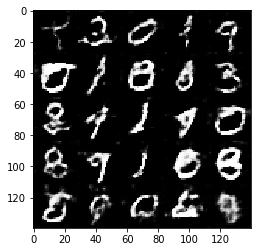

Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 2.2535
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 1.8308
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 0.9666... Generator Loss: 0.9453
Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 1.9377
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.1899


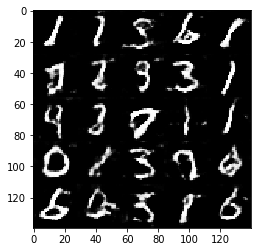

Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 1.8655
Epoch 1/2... Discriminator Loss: 1.7540... Generator Loss: 0.3061
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 2.6687
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.9106
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.7354
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 2.4220
Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 1.3201


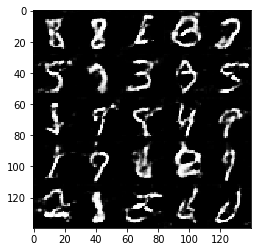

Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 0.7747... Generator Loss: 1.9230
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 3.6361... Generator Loss: 0.0428
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 1.7148
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 0.7657


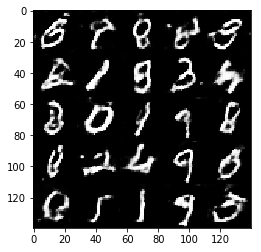

Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.6174
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.1325
Epoch 2/2... Discriminator Loss: 1.4666... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 1.8287... Generator Loss: 0.2399
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.6951
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 1.9334
Epoch 2/2... Discriminator Loss: 2.0332... Generator Loss: 0.2388
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.4083


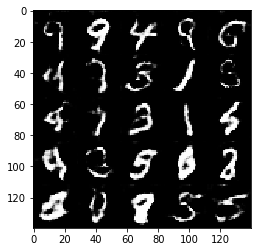

Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 2.4743
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 2.2422... Generator Loss: 0.2197
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 2.2052... Generator Loss: 0.2056
Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.3648
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 0.8723


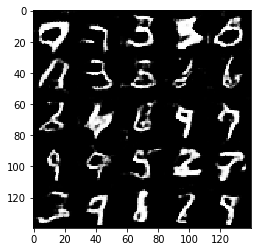

Epoch 2/2... Discriminator Loss: 2.4384... Generator Loss: 0.2293
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.0678
Epoch 2/2... Discriminator Loss: 2.3644... Generator Loss: 0.1381
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 0.6918... Generator Loss: 2.8108
Epoch 2/2... Discriminator Loss: 1.6784... Generator Loss: 0.3879


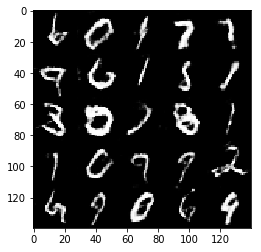

Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 2.5237
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 2.2624
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 1.5557... Generator Loss: 0.4111
Epoch 2/2... Discriminator Loss: 1.7706... Generator Loss: 0.2974
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 0.9092


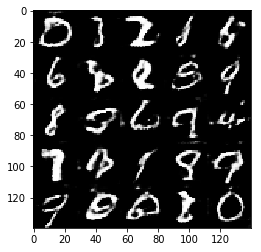

Epoch 2/2... Discriminator Loss: 1.6053... Generator Loss: 0.3216
Epoch 2/2... Discriminator Loss: 1.5841... Generator Loss: 0.3846
Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.4212
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.4625
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 1.6273
Epoch 2/2... Discriminator Loss: 1.6816... Generator Loss: 4.0260
Epoch 2/2... Discriminator Loss: 2.3232... Generator Loss: 0.3460
Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 1.4766


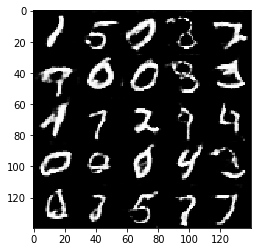

Epoch 2/2... Discriminator Loss: 1.8745... Generator Loss: 0.2818
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.9434
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.6715... Generator Loss: 0.3457
Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 2.6784
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.0373


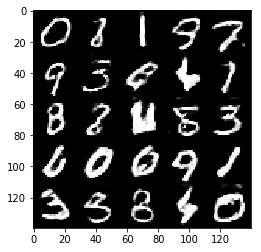

Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 1.4176
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 3.1906
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.1863
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.2981
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.3664
Epoch 2/2... Discriminator Loss: 1.5651... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.0736


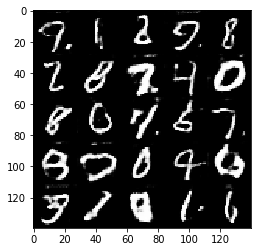

Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 1.9328
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 0.6464
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.0981
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.4797
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.1661
Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 3.0155
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 1.1305
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.5906


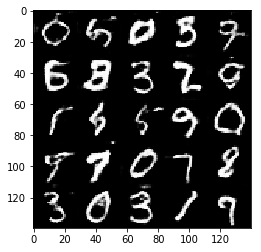

Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.5649
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 2.0265


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0648... Generator Loss: 0.1804
Epoch 1/1... Discriminator Loss: 1.8081... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 3.4360... Generator Loss: 1.7429
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 2.5228... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 2.2281
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.8994
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.9971... Generator Loss: 0.3073
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.0400


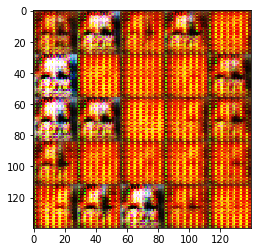

Epoch 1/1... Discriminator Loss: 0.1721... Generator Loss: 3.1276
Epoch 1/1... Discriminator Loss: 4.8691... Generator Loss: 0.0292
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 5.9798
Epoch 1/1... Discriminator Loss: 0.1234... Generator Loss: 3.4365
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 2.0501
Epoch 1/1... Discriminator Loss: 2.5416... Generator Loss: 3.5847
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 3.6370
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 1.7493
Epoch 1/1... Discriminator Loss: 0.6636... Generator Loss: 0.9304


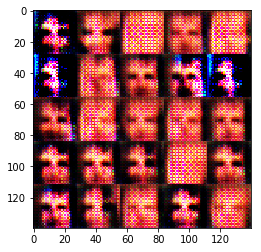

Epoch 1/1... Discriminator Loss: 2.3557... Generator Loss: 8.5611
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 2.7390
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 5.7415
Epoch 1/1... Discriminator Loss: 5.6449... Generator Loss: 6.1024
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.0123
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 2.2503


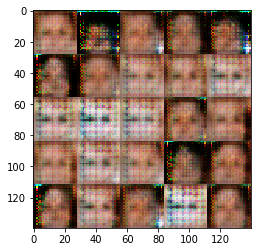

Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 3.0235
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 2.2769


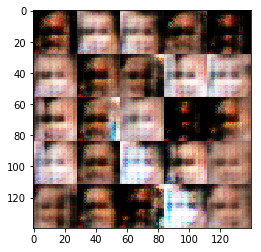

Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 2.3389
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.6021


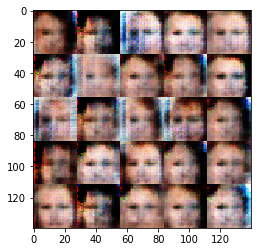

Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 2.0608... Generator Loss: 0.1848
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.4188
Epoch 1/1... Discriminator Loss: 1.7396... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 2.4929
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.2254


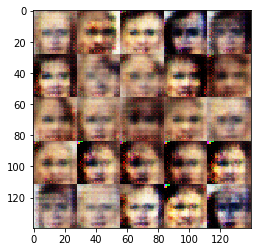

Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 2.0619
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.6910
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 2.0619


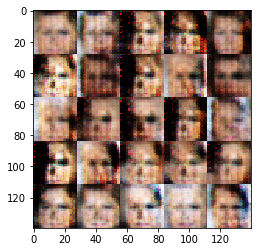

Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.7017
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 2.0059
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 2.2530
Epoch 1/1... Discriminator Loss: 3.0328... Generator Loss: 5.0430
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 0.9778


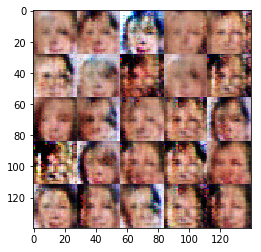

Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 2.0495
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.5189


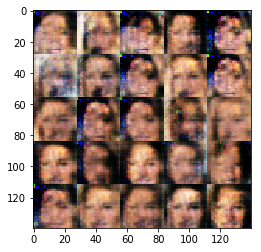

Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 2.2219
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 2.8847
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 2.1515


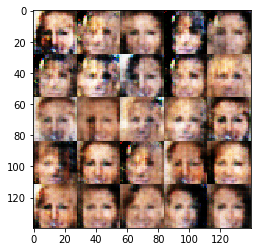

Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 2.1930
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.7382
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.0805


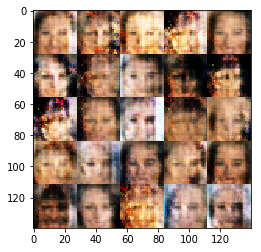

Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.4283
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.5136
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.5900


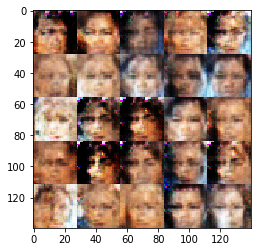

Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.7104
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.7652
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.4227
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4305


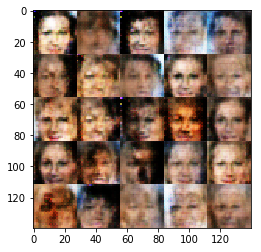

Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 2.1721
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 2.1822
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.1127


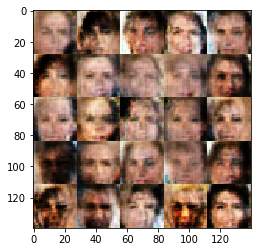

Epoch 1/1... Discriminator Loss: 2.1370... Generator Loss: 2.1680
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6181


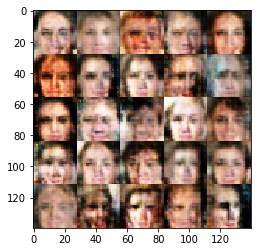

Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.5036
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 2.0664
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.4275


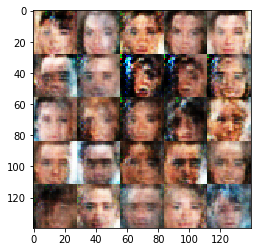

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 2.3334... Generator Loss: 0.1773
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 2.0903
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.7201


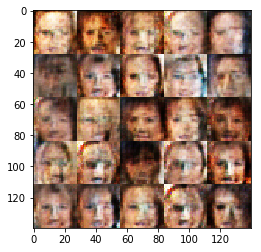

Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.8051... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.2533


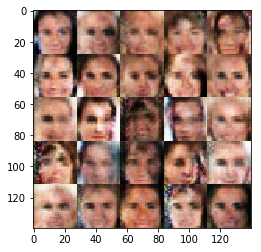

Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.3737
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.4382
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.6114


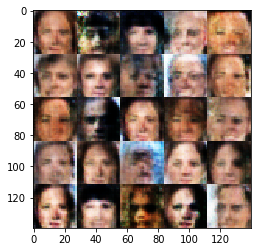

Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.6919


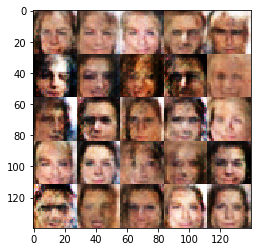

Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5185


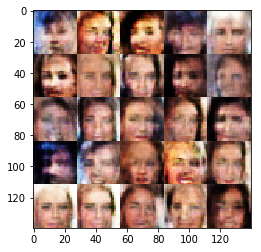

Epoch 1/1... Discriminator Loss: 2.6055... Generator Loss: 3.3912
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.9004


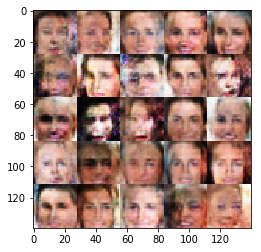

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.8798


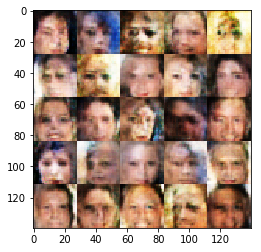

Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 2.8941


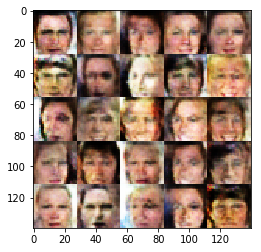

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.6231
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.1613


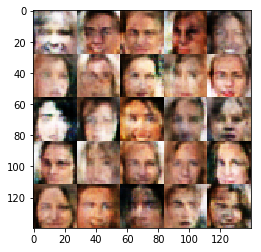

Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.6543
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.4614


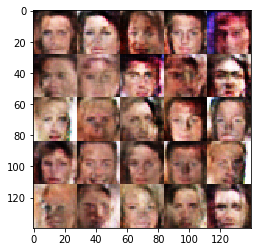

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 1.6583


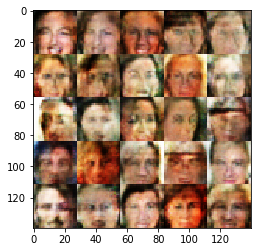

Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 2.1943
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.9266


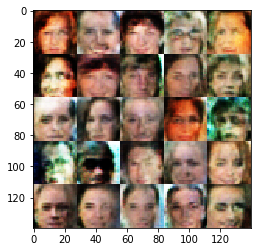

Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.6949... Generator Loss: 0.3162


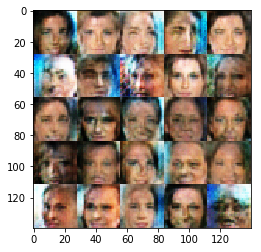

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.6909
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.2606


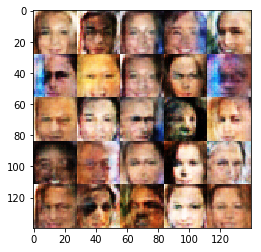

Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.2255


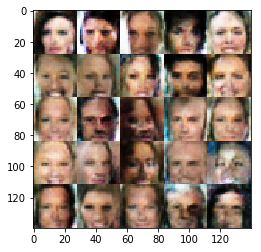

Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 2.4558


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.